## Imports

In [18]:
#%pip install -U albumentations>=3.0.0
#!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

In [19]:
%cd C:/Users/pso9kor/OneDrive - Bosch Group/Documents/03_ACE/15_Projects/semanctic-segmentation-tasm
import tensorflow_advanced_segmentation_models as tasm

C:\Users\pso9kor\OneDrive - Bosch Group\Documents\03_ACE\15_Projects\semanctic-segmentation-tasm


In [20]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from keras.utils import to_categorical
%matplotlib inline
import matplotlib.pyplot as plt

## Directories and Global Variables

In [21]:
# Data Handling
DATA_DIR = r"C:\Users\pso9kor\Datasets\CeyMo"

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/mask_annotations')
max_samples_training = 10000
x_valid_dir = os.path.join(DATA_DIR, 'test/images')
y_valid_dir = os.path.join(DATA_DIR, 'test/mask_annotations')
max_samples_validation = 2000
x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/mask_annotations')
max_samples_test = 2000

print(os.path.exists(x_train_dir))

N_CLASSES = 12
batch_size = 4
HEIGHT = 256
WIDTH = 256
image_shape = [HEIGHT, WIDTH]
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"
WWO_AUG = True # train data with and without augmentation

train_shuffle = True
val_shuffle = True
augment = False
shuffle = True
seed = 29598
epochs = 10
final_epochs = 100

True


In [22]:
tasm.helpers.get_files_recursive(x_train_dir)[:2], tasm.helpers.get_files_recursive(y_train_dir)[:2]

(['C:\\Users\\pso9kor\\Datasets\\CeyMo\\train/images\\1.jpg',
  'C:\\Users\\pso9kor\\Datasets\\CeyMo\\train/images\\10.jpg'],
 ['C:\\Users\\pso9kor\\Datasets\\CeyMo\\train/mask_annotations\\1.png',
  'C:\\Users\\pso9kor\\Datasets\\CeyMo\\train/mask_annotations\\10.png'])

## Define the Label Classes

In [23]:
from collections import namedtuple

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                      id    trainId   category  catId    hasInstances   ignoreInEval        color
    Label(  'unlabeled'             ,  0 ,        0 , 'void'    , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'bus lane'              ,  1 ,        1 , 'void'    , 0       , False        , True         , (  0,255,255) ),
    Label(  'cycle lane'            ,  2 ,        2 , 'void'    , 0       , False        , True         , (  0,128,255) ),
    Label(  'diamond'               ,  3 ,        3 , 'void'    , 0       , False        , True         , (178,102,255) ),
    Label(  'junction box'          ,  4 ,        4 , 'void'    , 0       , False        , True         , (255,255, 51) ),
    Label(  'left arrow'            ,  5 ,        5 , 'void'    , 0       , False        , True         , (255,102,178) ),
    Label(  'pedestrian crossing'   ,  6 ,        6 , 'void'    , 0       , False        , True         , (255,255,  0) ),
    Label(  'right arrow'           ,  7 ,        7 , 'flat'    , 1       , False        , False        , (255,  0,127) ),
    Label(  'straight arrow'        ,  8 ,        8 , 'flat'    , 1       , False        , False        , (255,  0,255) ),
    Label(  'slow'                  ,  9 ,        9 , 'flat'    , 1       , False        , True         , (  0,255,  0) ),
    Label(  'straight-left arrow'   , 10 ,       10 , 'flat'    , 1       , False        , True         , (255,128,  0) ),
    Label(  'straight-right arrow'  , 11 ,       11 , 'flat'    , 1       , False        , True         , (255,  0,  0) )
]

In [24]:
labels_color = [list(labels[k].color) for k in range(len(labels)) if labels[k].trainId >= 0 and labels[k].trainId < 255]
labels_name = [labels[k].name for k in range(len(labels)) if labels[k].trainId >= 0 and labels[k].trainId < 255]

print("Number of classes - ", len(labels_color))
print("\n")
for name, color in zip(labels_name, labels_color):
    print(f"{name} - {color}")

assert N_CLASSES == len(labels_color)

Number of classes -  12


unlabeled - [0, 0, 0]
bus lane - [0, 255, 255]
cycle lane - [0, 128, 255]
diamond - [178, 102, 255]
junction box - [255, 255, 51]
left arrow - [255, 102, 178]
pedestrian crossing - [255, 255, 0]
right arrow - [255, 0, 127]
straight arrow - [255, 0, 255]
slow - [0, 255, 0]
straight-left arrow - [255, 128, 0]
straight-right arrow - [255, 0, 0]


## Data Augmentation Functions

In [25]:
# define heavy augmentations
def get_training_augmentation(height, width):
    train_transform = [
        A.HorizontalFlip(p=0.3),

        # A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0.2, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        # A.RandomCrop(height=height, width=width, always_apply=True),
        A.Resize(height, width, always_apply=True),

        # A.GaussNoise(p=0.2),
        # A.Perspective(p=0.5),

        # A.OneOf(
        #     [
        #         A.CLAHE(p=1),
        #         A.RandomBrightnessContrast(p=1),
        #         A.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),

        # A.OneOf(
        #     [
        #         A.Sharpen(p=1),
        #         A.Blur(blur_limit=3, p=1),
        #         A.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

        # A.OneOf(
        #     [
        #         A.RandomContrast(p=1),
        #         A.HueSaturationValue(p=1),
        #     ],
        #     p=0.9,
        # ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation(height, width):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(height, width),
        A.Resize(height, width, always_apply=True)
    ]
    return A.Compose(test_transform)

def data_get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

## Data Generation Functions

In [26]:
# build data pipeline
# for training
trainGen = tasm.data_generator.DatasetGenerator(data_path=(x_train_dir, y_train_dir),
                                                max_samples=max_samples_training,
                                                image_shape=image_shape,
                                                augment=augment,
                                                class_colors=labels_color,
                                                shuffle=shuffle,
                                                batch_size=batch_size,
                                                epochs=epochs)
dataTrain, nsamples_train, nbatches_train = trainGen()
print("Built data pipeline for {} training samples with {} batches per epoch".format(nsamples_train, nbatches_train))

# for validation
validGen = tasm.data_generator.DatasetGenerator(data_path=(x_valid_dir, y_valid_dir),
                                                max_samples=max_samples_validation,
                                                image_shape=image_shape,
                                                augment=augment,
                                                class_colors=labels_color,
                                                shuffle=shuffle,
                                                batch_size=batch_size,
                                                epochs=epochs)
dataValid, nsamples_valid, nbatches_valid = validGen()
print("Built data pipeline for {} validation samples with {} batches per epoch".format(nsamples_valid, nbatches_valid))

Built data pipeline for 2099 training samples with 524 batches per epoch
Built data pipeline for 788 validation samples with 197 batches per epoch


#### Example

(256, 256, 3)
(256, 256, 12)


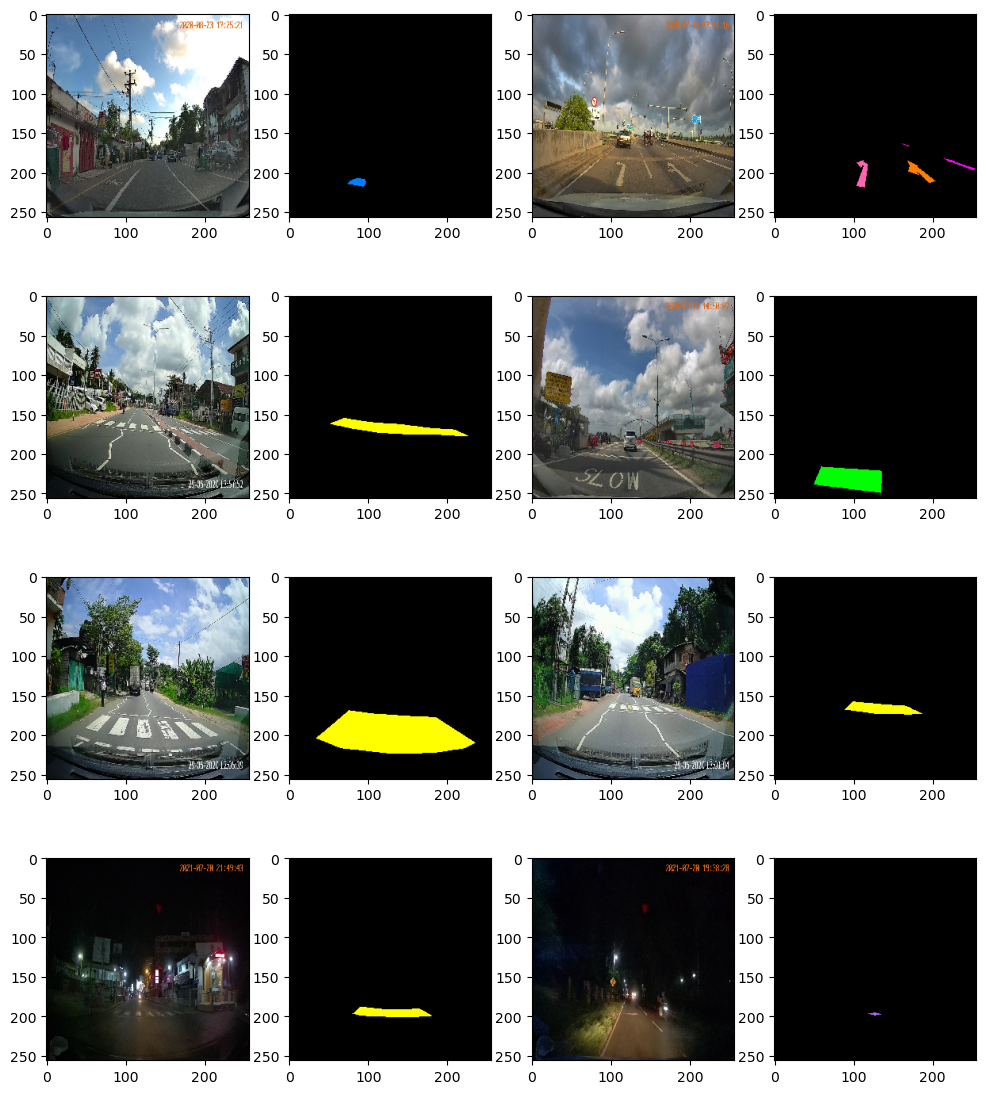

In [27]:
l=4
plt.figure(figsize=(12,14))
for e, i in enumerate(dataTrain):
    plt.subplot(l, 4, e*4+1)
    plt.imshow(i[0][0])
    plt.subplot(l, 4, e*4+2)
    plt.imshow(tasm.utils.decode_one_hot_op(i[1][0], labels_color))
    plt.subplot(l, 4, e*4+3)
    plt.imshow(i[0][1])
    plt.subplot(l, 4, e*4+4)
    plt.imshow(tasm.utils.decode_one_hot_op(i[1][1], labels_color))
    if e >= l-1:
        break

sample_image = i[0][0]
sample_mask = i[1][0]
print(sample_image.shape)
print(sample_mask.shape)

## Create the Model

In [28]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.DANet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

### Define the Optimizer as well as Losses, Metrics and Callbacks

In [29]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)

model.run_eagerly = False

callbacks = [
             tf.keras.callbacks.ModelCheckpoint("model.hdf5", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

### Short check if model works properly

(1, 256, 256, 12)
(256, 256, 1)
SparseCategoricalCrossentroy: 2.986903
Iou-Score: 0.026090387
categorical Focal Dice Loss: 1.0052505


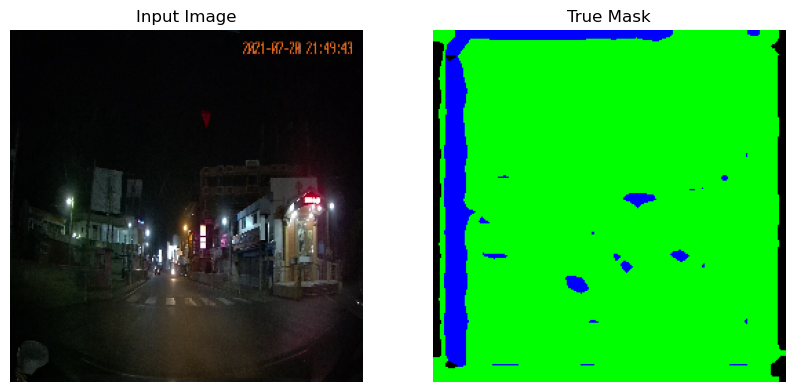

In [30]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    output_model = model(sample_image[tf.newaxis, ...])
    print(output_model.shape)
    
    output_mask = create_mask(output_model)
    print(output_mask.shape)

    scce = tf.keras.losses.CategoricalCrossentropy()
    print("SparseCategoricalCrossentroy: " + str(scce(sample_mask, output_model[0]).numpy()))
    print("Iou-Score: " + str(tasm.losses.iou_score(sample_mask, output_model[0]).numpy()))
    print("categorical Focal Dice Loss: " + str(categorical_focal_dice_loss(sample_mask, output_model[0]).numpy()))

    display([sample_image, K.one_hot(K.squeeze(output_mask, axis=-1), 3)])
    
show_predictions()

In [31]:
model.summary()

Model: "da_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSampling  multiple                 0         
 2D)                                                             
                                                                 
 model_1 (Functional)        [(None, 128, 128, 144),   184645    
                              (None, 64, 64, 192),               
                              (None, 32, 32, 288)]               
                                                                 
 convolution_bn_activation_1  multiple                 664832    
 1 (ConvolutionBnActivation)                                     
                                                                 
 convolution_bn_activation_1  multiple                 664832    
 2 (ConvolutionBnActivation)                                     
                                                          

## Training

##### 1) Train model with freezed backbone only on train data
##### 2) Train completely unfreezed model with train and validation data

#### (1) Train model with freezed backbone only on train data

In [32]:
## Set Backbone trainable to False
for layer in model.layers:
    if "model" in layer.name:
        layer.trainable = False
    print(layer.name + ": " + str(layer.trainable))

up_sampling2d_1: True
model_1: False
convolution_bn_activation_11: True
convolution_bn_activation_12: True
pam__module_1: True
cam__module_1: True
convolution_bn_activation_16: True
convolution_bn_activation_17: True
dropout_3: True
dropout_4: True
dropout_5: True
convolution_bn_activation_18: True
convolution_bn_activation_19: True
convolution_bn_activation_20: True
concatenate_4: True
concatenate_5: True
convolution_bn_activation_21: True


In [33]:
history = model.fit(
    dataTrain,
    steps_per_epoch=nbatches_train,
    epochs=epochs,
    callbacks=callbacks
    )

Epoch 1/10


524/524 [==============================] - 83s 149ms/step - loss: 0.9197 - iou_score: 0.7203 - lr: 0.2000
Epoch 2/10
 66/524 [==>...........................] - ETA: 1:08 - loss: 0.9031 - iou_score: 0.7255

KeyboardInterrupt: 

##### Plot Training IoU Scores and Losses

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

#### (2) Train completely unfreezed model with train and validation data

In [ ]:
# Make whole model trainable and use validation set
for layer in model.layers:
    layer.trainable = True
    print(layer.name + ": " + str(layer.trainable))

up_sampling2d: True
model: True
convolution_bn_activation: True
convolution_bn_activation_1: True
pam__module: True
cam__module: True
convolution_bn_activation_5: True
convolution_bn_activation_6: True
dropout: True
dropout_1: True
dropout_2: True
convolution_bn_activation_7: True
convolution_bn_activation_8: True
convolution_bn_activation_9: True
concatenate_1: True
concatenate_2: True
convolution_bn_activation_10: True


##### Define the Optimizer as well as Losses, Metrics and Callbacks

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.hdf5", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [ ]:
history = model.fit(
    TrainSetwwoAug,
    steps_per_epoch=nbatches_train,
    initial_epoch=epochs,
    epochs=final_epochs,
    callbacks=callbacks,
    validation_data=ValidationSet,
    validation_steps=nbatches_valid,
    )

##### Plot Training IoU Scores and Losses

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation on Test Data

In [ ]:
scores = model.evaluate(TestSet, steps=101)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    if metric != "accuracy":
        metric = metric.__name__
    print("mean {}: {:.5}".format(metric, value))

## Visual Examples on Test Data

In [ ]:
plt.imshow(decode_one_hot(model.predict(image)[0], labels_color))
plt.show()

In [ ]:
model.predict(image)[0].shape

In [ ]:
pr_mask.shape